# Mean-shift
segmentation / clustering algorithm

[paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.76.8968&rep=rep1&type=pdf): Comaniciu, Dorin, and Peter Meer. "Mean shift: A robust approach toward feature space analysis." IEEE Transactions on pattern analysis and machine intelligence 24.5 (2002): 603-619.

In [6]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import skimage.io

## Load an image

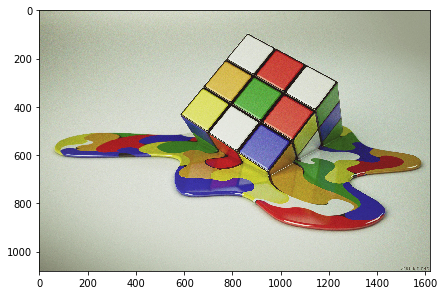

In [7]:
im = skimage.io.imread('cube1.jpg')
plt.figure(figsize=(7,7))
plt.imshow(im)

In [8]:
im.shape

(1080, 1619, 3)